In [132]:
%matplotlib inline

import pandas as pd
from sklearn.metrics import auc
import matplotlib.pyplot as plt # standard Python plotting library
import numpy as np  # fundamental package for scientific computing, handles arrays and math
import scipy.signal
from scipy.signal import find_peaks, peak_prominences
import scipy.stats as stats
from scipy.stats import zscore
from pathlib import Path
import tdt # import the tdt library
import seaborn as sns
from matplotlib import rcParams
import os
import numpy as np
import glob
from scipy.signal import find_peaks, peak_prominences, peak_widths
import copy

In [145]:
isosbestic = '_415A'
dopa='_465A'
CHANNEL = 1
TRANGE       = [-5, 10]
BASELINE_PER = [-5, -0]
event_type = 'RNP_'
het_path = r"C:\Users\User\Tischfield_Lab\Fiber_Photo\Sample_Tank\Progressive ratio day 1 tanks\het/*" # path to het folder remember /*
wt_path = r"C:\Users\User\Tischfield_Lab\Fiber_Photo\Sample_Tank\Progressive ratio day 1 tanks\wt/*"

def readfiles(blockpath):
    data = tdt.read_block(blockpath, evtype=['epocs','streams'], channel=CHANNEL)
    data = tdt.epoc_filter(data, event_type, t=TRANGE)  #filters the chosen epocs (RNP_) and time set around those epocs
    # More examples of list comprehensions
    min1 = np.min([np.size(x) for x in data['streams'][dopa].filtered])
    min2 = np.min([np.size(x) for x in data['streams'][isosbestic].filtered])
    data['streams'][dopa].filtered = [x[1:min1] for x in data['streams'][dopa].filtered]
    data['streams'][isosbestic].filtered = [x[1:min2] for x in data['streams'][isosbestic].filtered]
    N = 10 # Average every 10 samples into 1 value
    # Downsample and average 10x via a moving window mean
    N = 10 # Average every 10 samples into 1 value
    F415 = []
    F465 = []
    for lst in data['streams'][isosbestic].filtered: 
        small_lst = []
        for i in range(0, min2, N):
            small_lst.append(np.mean(lst[i:i+N-1])) # This is the moving window mean
        F415.append(small_lst)

    for lst in data['streams'][dopa].filtered: 
        small_lst = []
        for i in range(0, min1, N):
            small_lst.append(np.mean(lst[i:i+N-1]))
        F465.append(small_lst)

    #Create a mean signal, standard error of signal, and DC offset
    meanF415 = np.mean(F415, axis=0)
    meanF465 = np.mean(F465, axis=0)
    Y_fit_all = []
    Y_dF_all = []
    for x, y in zip(F415, F465):
        x = np.array(x)
        y = np.array(y)
        bls = np.polyfit(x, y, 1)
        fit_line = np.multiply(bls[0], x) + bls[1]
        Y_fit_all.append(fit_line)
        Y_dF_all.append(y-fit_line)
    return Y_dF_all, data.epocs.RNP_.onset


In [146]:
h_dict = {}
w_dict = {}

for file in glob.glob(het_path):
    dFF, rnps = readfiles(file)
    h_dict[os.path.basename(file)]={"dFF": dFF,
                                    "rnps": rnps
                                    }
    
for file in glob.glob(wt_path):
    dFF, rnps = readfiles(file)
    w_dict[os.path.basename(file)]={"dFF": dFF,
                                    "rnps": rnps,
                                    }

read from t=0s to t=3599.1s
read from t=0s to t=3599.2s
read from t=0s to t=3599.1s
read from t=0s to t=3599.23s
read from t=0s to t=3599.39s
read from t=0s to t=3599.1s
read from t=0s to t=3599.19s
read from t=0s to t=3599.08s
read from t=0s to t=3599.2s
read from t=0s to t=3599.2s
read from t=0s to t=3599.08s
read from t=0s to t=3599.09s
read from t=0s to t=3599.11s
read from t=0s to t=3599.09s
read from t=0s to t=3599.09s
read from t=0s to t=3599.21s
read from t=0s to t=3599.31s


In [147]:
het_early = []
het_late = []
for key in h_dict.keys():
    for i in range(len(h_dict[key]['rnps'])):
        if i < 5:
            het_early.append(h_dict[key]['dFF'][i])
        elif i > 14:
            het_late.append(h_dict[key]['dFF'][i])

wt_early = []
wt_late = []
for key in w_dict.keys():
    for i in range(len(w_dict[key]['rnps'])):
        if i < 5:
            wt_early.append(w_dict[key]['dFF'][i])
        elif i > 14:
            wt_late.append(w_dict[key]['dFF'][i])

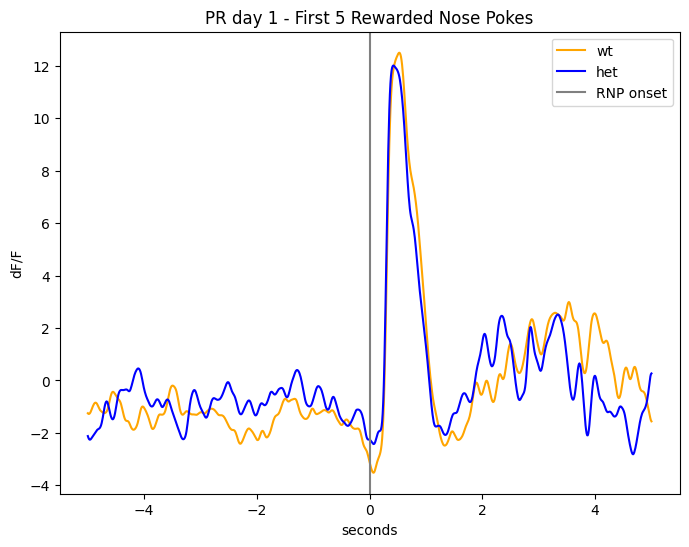

In [148]:
T = np.linspace(-5, 5, int(10*101.8))

fig0 = plt.figure(figsize=(8,6))
ax = fig0.add_subplot(111)
ax.plot(T, np.mean(wt_early, axis = 0), color = 'orange', label = 'wt')
ax.plot(T, np.mean(het_early, axis = 0), color = 'blue', label = 'het')
ax.set_title('PR day 1 - First 5 Rewarded Nose Pokes')
ax.set_ylabel('dF/F')
ax.set_xlabel('seconds')
ax.axvline(x = 0, color = 'gray', label = 'RNP onset')
ax.legend()


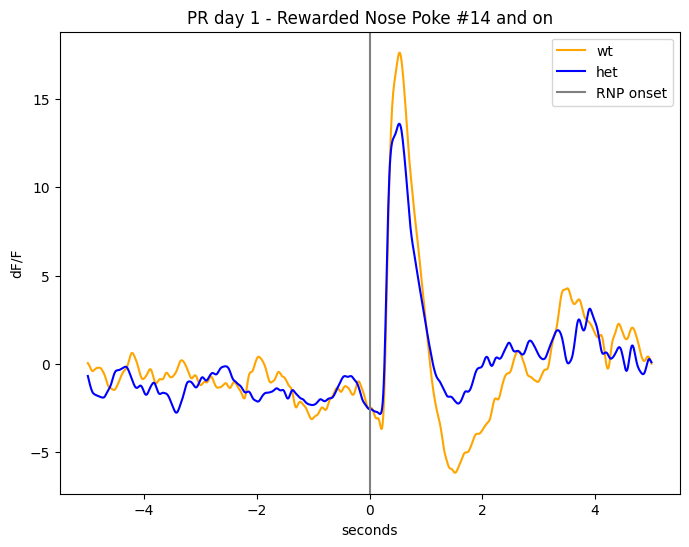

In [149]:
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(111)
ax1.plot(T, np.mean(wt_late, axis = 0), color = 'orange', label = 'wt')
ax1.plot(T, np.mean(het_late, axis = 0), color = 'blue', label = 'het')
ax1.set_title('PR day 1 - Rewarded Nose Poke #14 and on')
ax1.set_ylabel('dF/F')
ax1.set_xlabel('seconds')
ax1.axvline(x = 0, color = 'gray', label = 'RNP onset')
ax1.legend()

In [150]:
trimmed_ts = []
trimmed_idx = []

for i in range(len(T)):
    if T[i]>=0 and T[i]<=2:
        trimmed_ts.append(T[i])
        trimmed_idx.append(i)

for key in h_dict.keys():
    trimmed_z_key = []    
    for i in range(len(h_dict[key]['dFF'])):
        trimmed_z = []
        for j in range(len(h_dict[key]['dFF'][i])):
            if j in trimmed_idx:
                trimmed_z.append(h_dict[key]['dFF'][i][j])
        trimmed_z_key.append(trimmed_z)
    h_dict[key]['trimmed_z-score']=trimmed_z_key

for key in w_dict.keys():
    trimmed_z_key = []    
    for i in range(len(w_dict[key]['dFF'])):
        trimmed_z = []
        for j in range(len(w_dict[key]['dFF'][i])):
            if j in trimmed_idx:
                trimmed_z.append(w_dict[key]['dFF'][i][j])
        trimmed_z_key.append(trimmed_z)
    w_dict[key]['trimmed_z-score']=trimmed_z_key

In [151]:
trimmed_het_early = []
trimmed_het_late = []
for key in h_dict.keys():
    for i in range(len(h_dict[key]['rnps'])):
        if i < 5:
            trimmed_het_early.append(h_dict[key]['trimmed_z-score'][i])
        elif i > 14:
            trimmed_het_late.append(h_dict[key]['trimmed_z-score'][i])

trimmed_wt_early = []
trimmed_wt_late = []
for key in w_dict.keys():
    for i in range(len(w_dict[key]['rnps'])):
        if i < 5:
            trimmed_wt_early.append(w_dict[key]['trimmed_z-score'][i])
        elif i > 14:
            trimmed_wt_late.append(w_dict[key]['trimmed_z-score'][i])

In [152]:
auclst = []
for df in trimmed_wt_early:
    auclst.append(auc(trimmed_ts, df))

In [153]:
for key in h_dict.keys():
    auc_key = []
    for i in range(len(h_dict[key]['trimmed_z-score'])):
        auc_key.append(auc(trimmed_ts, h_dict[key]['trimmed_z-score'][i]))
    h_dict[key]['auc']=auc_key
for key in w_dict.keys():
    auc_key = []
    for i in range(len(w_dict[key]['trimmed_z-score'])):
        auc_key.append(auc(trimmed_ts, w_dict[key]['trimmed_z-score'][i]))
    w_dict[key]['auc']=auc_key

h_auc_mean = []
w_auc_mean = []

for key in h_dict.keys():
    h_auc_mean.append(np.mean(h_dict[key]['auc']))

for key in w_dict.keys():
    w_auc_mean.append(np.mean(w_dict[key]['auc']))

In [154]:
for key in h_dict.keys():
    hpeak_key = []
    hwidth_key = []
    for i in range(len(h_dict[key]['trimmed_z-score'])):
        hpeaks = find_peaks(h_dict[key]['trimmed_z-score'][i], prominence = 1)
        # if len(hpeaks[0]!=0):
        hwidths = peak_widths(h_dict[key]['trimmed_z-score'][i], hpeaks[0])
        hpeak_key.append(hpeaks[0])
        hwidth_key.append(hwidths[2])

    h_dict[key]['peaks']=hpeak_key
    h_dict[key]['widths']=hwidth_key
    
for key in w_dict.keys():
    wpeak_key = []
    wwidth_key = []
    for i in range(len(w_dict[key]['trimmed_z-score'])):
        wpeaks = find_peaks(w_dict[key]['trimmed_z-score'][i], prominence = 2)
        # if len(wpeaks[0]!=0):
        wwidths = peak_widths(w_dict[key]['trimmed_z-score'][i], wpeaks[0])
        wpeak_key.append(wpeaks[0])
        wwidth_key.append(wwidths[2])

    w_dict[key]['peaks']=wpeak_key
    w_dict[key]['widths']=wwidth_key

In [155]:
for key in h_dict.keys():
    prominence_key = []
    for i in range(len(h_dict[key]['trimmed_z-score'])):
        prominence_key.append(peak_prominences(h_dict[key]['trimmed_z-score'][i], h_dict[key]['peaks'][i])[0])
    h_dict[key]['peak_prominences'] = prominence_key

for key in w_dict.keys():
    prominence_key = []
    for i in range(len(w_dict[key]['trimmed_z-score'])):
        prominence_key.append(peak_prominences(w_dict[key]['trimmed_z-score'][i], w_dict[key]['peaks'][i])[0])
    w_dict[key]['peak_prominences'] = prominence_key

h_prominence_means = []
for key in h_dict.keys():
    x = 0
    n = 0
    for prom in range(len(h_dict[key]['peak_prominences'])):
        if len(h_dict[key]['peak_prominences'][prom])!=0: 
            for j in h_dict[key]['peak_prominences'][prom]:
                x = x+ j
                n+=1
    h_prominence_means.append(x/n)

w_prominence_means = []
for key in w_dict.keys():
    x = 0
    n = 0
    for prom in range(len(w_dict[key]['peak_prominences'])):
        if len(w_dict[key]['peak_prominences'][prom])!=0: 
            for j in w_dict[key]['peak_prominences'][prom]:
                x = x+ j
                n+=1
    w_prominence_means.append(x/n)


In [156]:
hdf = pd.DataFrame()
wdf = pd.DataFrame()
for i in range(len(h_auc_mean)):
    hdf.loc[i, 'genotype'] = 'het'
    hdf.loc[i, 'auc_mean'] = h_auc_mean[i]
    hdf.loc[i, 'peak_prominence'] = h_prominence_means[i]
for i in range(len(w_auc_mean)):
    wdf.loc[i, 'genotype'] = 'wt'
    wdf.loc[i, 'auc_mean']= w_auc_mean[i]
    wdf.loc[i, 'peak_prominence'] = w_prominence_means[i]
    # wdf.loc[i, 'width_mean'] = mean_width_wt[i]
df = hdf._append(wdf, ignore_index = True)